# 1 - Music Classification - Raw Audio only

## 1. Do the necessary imports

In [2]:
import os
import librosa

## 2. Save the music data into lists

In [3]:
DATASET_PATH = "Data/genres_original"

music_files, genres = [], []
# genres = sorted(os.listdir(DATASET_PATH))
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

x, y = [], []

for genre in genres:

    genre_path = os.path.join(DATASET_PATH, genre)

    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            if file.endswith(".wav"):
                file_path = os.path.join(genre_path, file)
                try:
                    # Load audio file. sr=22050 is the default sample rate, although it can be change
                    signal, sr = librosa.load(file_path, sr=22050)
                    
                    x.append(signal)
                    y.append(genres.index(genre))  # Store the genre's index instead of its name
                except Exception as e:
                    print(file_path)
                    print(e)
                    continue
    
len(x[0]), y[0], genres

(661794,
 0,
 ['blues',
  'classical',
  'country',
  'disco',
  'hiphop',
  'jazz',
  'metal',
  'pop',
  'reggae',
  'rock'])

## 3 - Preprocessing the Data

In [4]:
import numpy as np
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

# Find the maximum length of the audio signals
max_length = max([len(signal) for signal in x])

# Set the maximum length to 5 seconds (22050 * 5 samples)
max_length_five_seconds = 22050 * 5

# Pad the sequences to make sure all audio signals have the same length
x_padded = pad_sequences(x, maxlen=max_length_five_seconds, dtype='float32', padding='post')

# Normalize the audio signals
x_padded = x_padded / np.max(np.abs(x_padded), axis=1, keepdims=True)

# Convert the genre labels to one-hot encoding
y_encoded = to_categorical(y, num_classes=len(genres))

# Convert x_padded to numpy array
x_padded = np.array(x_padded)

# Check the shapes of your data
print(f"Shape of x_padded: {x_padded.shape}")
print(f"Shape of y_encoded: {y_encoded.shape}")

Shape of x_padded: (1000, 110250)
Shape of y_encoded: (1000, 10)


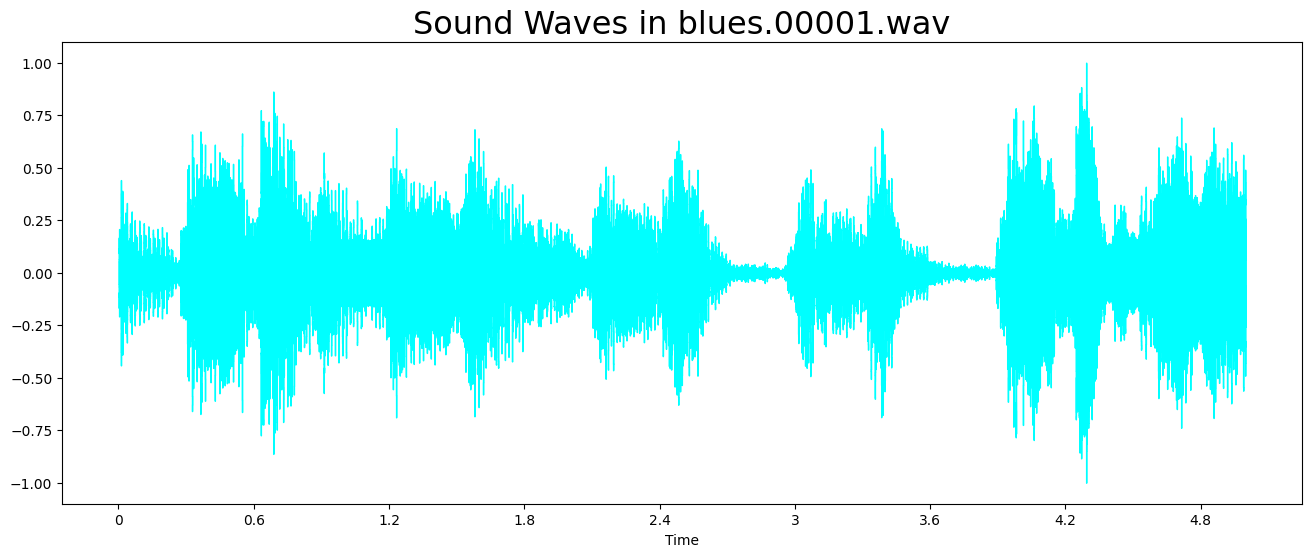

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = x_padded[1], sr = sr, color = "#00ffff");
plt.title("Sound Waves in blues.00001.wav", fontsize = 23);

## 4 - Split the Dataset

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

len(x_train[0])

Shape of x_train: (800, 110250)
Shape of x_test: (200, 110250)
Shape of y_train: (800, 10)
Shape of y_test: (200, 10)


110250

## 5 - sklearn for testing the data

In [6]:
from sklearn.svm import SVC

x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_test_flattened = x_test.reshape(x_test.shape[0], -1)
y_train_flattened = np.argmax(y_train, axis=1)
y_test_flattened = np.argmax(y_test, axis=1)

model = SVC()
model.fit(x_train_flattened, y_train_flattened)

SVC()

In [7]:
y_pred = model.predict(x_test_flattened)

## 6 - Get the accuracy of SVC

In [8]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_flattened, y_pred)

accuracy

0.14

## 7 - Take the music through a Keras model

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

# Define the model architecture
model = Sequential([
    layers.Dense(128, activation='relu', input_shape=(x_train_flattened.shape[1],)),
    layers.Dropout(0.2),  # Lower dropout rate
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),  # Lower dropout rate
    layers.Dense(len(genres), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summarize the model architecture
model.summary()


/Users/conorwoollatt/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │    14,112,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,121,034 (53.87 MB)

 Trainable params: 14,121,034 (53.87 MB)

 Non-trainable params: 0 (0.00 B)

## 8 - Fit the model

In [10]:
model.fit(x_train_flattened, y_train_flattened, validation_data=(x_test_flattened, y_test_flattened), epochs=5, batch_size=32)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0908 - loss: 2.6266 - val_accuracy: 0.2050 - val_loss: 2.8036
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6759 - loss: 1.0834 - val_accuracy: 0.1900 - val_loss: 2.9033
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8562 - loss: 0.5079 - val_accuracy: 0.2000 - val_loss: 3.0144
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8884 - loss: 0.4389 - val_accuracy: 0.2000 - val_loss: 3.1775
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9450 - loss: 0.2193 - val_accuracy: 0.2100 - val_loss: 3.2776


## 9 - Predict its accuracy

In [11]:
model.evaluate(x_test_flattened, y_test_flattened)

y_pred = model.predict(x_test_flattened)
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test_flattened, y_pred)

accuracy

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1935 - loss: 3.1771 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


0.21

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


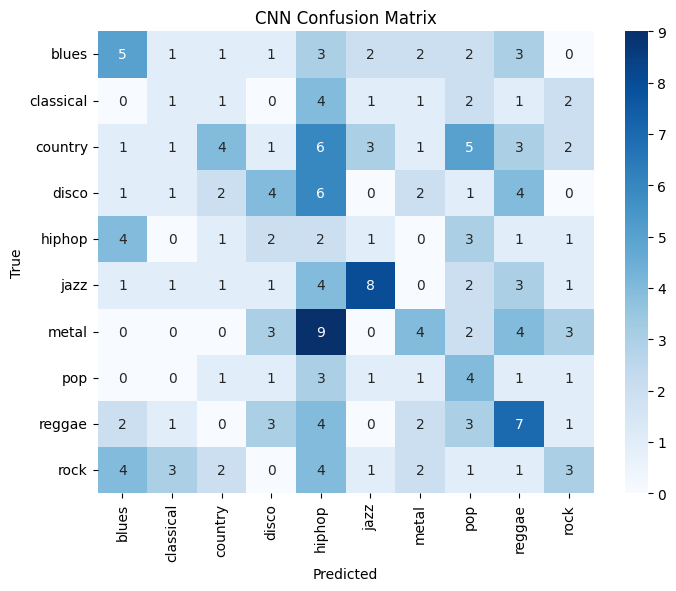

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict class indices
cnn_preds = np.argmax(model.predict(x_test), axis=1)

# Convert y_test from one-hot encoded format to integer format
y_test_int = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cnn_cm = confusion_matrix(y_test_int, cnn_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()